In [3]:
!pip install optuna
!pip install phik
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 13.8 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 71.0 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 112 kB 67.8 MB/s 
     |████████████████████████████████| 147 kB 70.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=3a3dd3e31ca3524f11dca3da357d1f17c51cdfbc524147ac605f26c6ba83b2d5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https:

In [4]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer 

from catboost import CatBoostClassifier, Pool

import phik

import optuna
from optuna import Trial

import random

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 
from scipy import stats
import numpy as np

pd.set_option("display.max_columns", 50)
sns.set_theme(style="darkgrid")

import torch
from torch import nn

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Подключимся к базе и выгрузим данные

In [6]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [7]:
engine = create_engine(connection_string) 

In [8]:
def count_string(table):
    query = f'''
    SELECT COUNT(*) count_string_in_df
    FROM {table}
    '''
    df = pd.read_sql_query(query,con=engine)
    return df

In [9]:
for i in ['telecom.internet', 'telecom.contract', 'telecom.personal', 'telecom.internet', 'telecom.phone']:
    print('Таблица: ' + i)
    display(count_string(i))

Таблица: telecom.internet


,count_string_in_df
0,5518


Таблица: telecom.contract


,count_string_in_df
0,7043


Таблица: telecom.personal


,count_string_in_df
0,7043


Таблица: telecom.internet


,count_string_in_df
0,5518


Таблица: telecom.phone


,count_string_in_df
0,6362


In [10]:
# функции для осмотра данных
def nan_count_sql(table, column):
    print(f'Таблица {table}, колонка {column}')
    query = f'''
    SELECT COUNT(*) {column}_nan_count
    FROM {table}
    WHERE {column} IS NULL
    '''
    df = pd.read_sql_query(query,con=engine)
    return df



def nan_for_full_df(table):
    for column in info_sql(table)['column_name'].unique():
        try:
            print('----------------------------------')
            display(nan_count_sql(table, column))
        except:
            print('Произошла ошибка')




def info_sql(table):
    query = f'''
    SELECT column_name, data_type
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE table_name = '{table}'
    '''

    df = pd.read_sql_query(query,con=engine)
    return df

In [11]:
query = f'''
SELECT *
FROM telecom.contract
LIMIT 20;
'''
df = pd.read_sql_query(query,con=engine)
df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


Есть проблема, что названия столбцов в 1 строке, а сами названия другие. Из-за этого не могу проверить с помощью SQL запроса пропуски

In [12]:
for i in ['internet', 'contract', 'personal', 'phone']:
    print('Таблица: ' + i)
    display(info_sql(i))

Таблица: internet


,column_name,data_type
0,c1,text
1,c2,text
2,c3,text
3,c4,text
4,c5,text
5,c6,text
6,c7,text
7,c8,text


Таблица: contract


,column_name,data_type
0,customerID,text
1,BeginDate,date
2,EndDate,date
3,Type,text
4,PaperlessBilling,text
5,PaymentMethod,text
6,MonthlyCharges,numeric
7,TotalCharges,numeric


Таблица: personal


,column_name,data_type
0,customerID,text
1,gender,text
2,SeniorCitizen,integer
3,Partner,text
4,Dependents,text


Таблица: phone


,column_name,data_type
0,c1,text
1,c2,text


In [13]:
# функция для загрузки датасетов
def pandas_df(table):
    query = f'''
            SELECT *
            FROM  {'telecom.' + table}
            '''
    return pd.read_sql_query(query,con=engine)

In [14]:
df_internet = pandas_df('internet')
df_phone = pandas_df('phone')
df_contract = pandas_df('contract')
df_personal = pandas_df('personal')

In [15]:
df_internet.columns = [i.lower() for i in df_internet.loc[0].values]
df_phone.columns = [i.lower() for i in df_phone.loc[0].values]
df_contract.columns = [i.lower() for i in df_contract.columns]
df_personal.columns = [i.lower() for i in df_personal.columns]
df_internet = df_internet.drop(0)
df_phone = df_phone.drop(0)

# internet

In [16]:
df_internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


In [18]:
len(df_internet['customerid'].unique())

5517

5517 уникальных пользователей

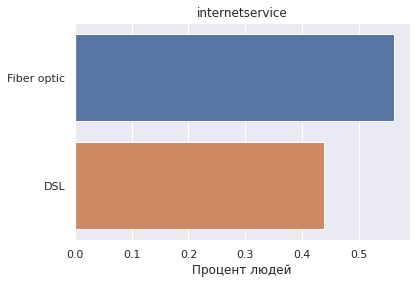

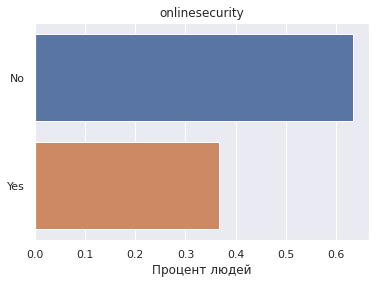

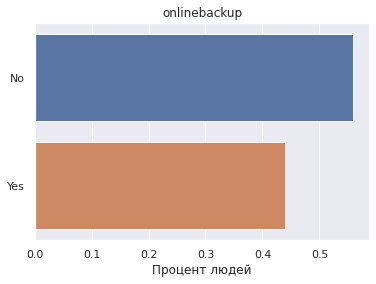

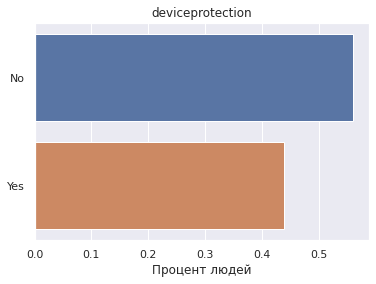

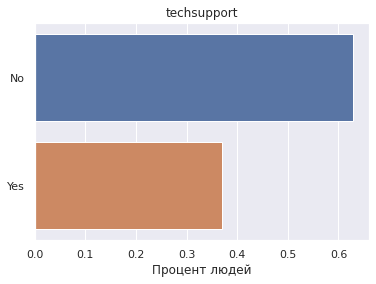

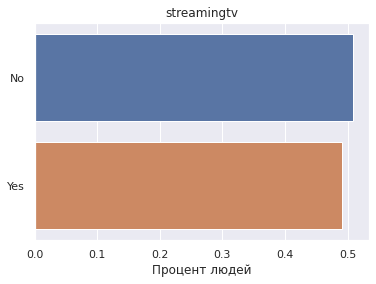

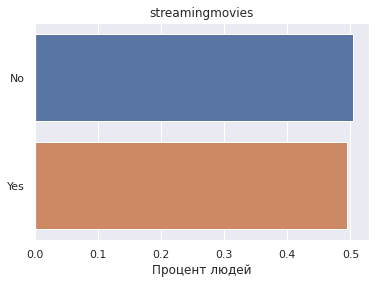

In [19]:
for column in df_internet.columns[1:]:
    plt.figure(figsize=(6, 4));
    sns.barplot(y=df_internet[column].value_counts(normalize=True).index, x=df_internet[column].value_counts(normalize=True));
    plt.xlabel('Процент людей');
    plt.title(column)

- **internetservice:** Большая часть людей имеют оптоволоконный кабель, остальные цифровую абонентскую линию.
- **onlinesecurity:** Большиство не блокирует небезопасные сайты. Возможно, они о них даже не знаю 
- **onlinebackup:** Больше половины не пользуются облачных хранением данных
- **deviceprotection :** Многие не пользуются услугой антивируса, предполагаю, что у них свой, но больше 40 процентов пользуются.
- **techsupport:** Больше половины не пользуются облачных хранением данных
- **streamingtv:** Почти половина на половину, т.е. половина людей пользуются стриминговыми услугами, а половина нет
- **streamingmovies:** Те, кто пользуются стриминговыми услушами, также пользуются катологами фильмов

# phone

In [20]:
df_phone.head()

,customerid,multiplelines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [21]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


In [22]:
len(df_phone['customerid'].unique())

6361

6361 уникальных пользователей

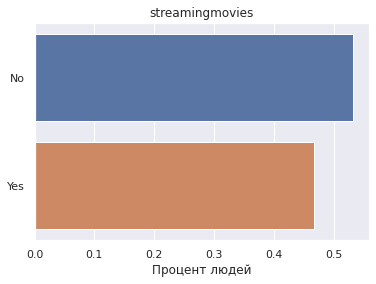

In [23]:
sns.barplot(y=df_phone['multiplelines'].value_counts(normalize=True).index, 
            x=df_phone['multiplelines'].value_counts(normalize=True));
plt.xlabel('Процент людей');
plt.title(column);

In [24]:
df_phone['multiplelines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: multiplelines, dtype: float64

53 процента человек не подключили телефонный аппарат к нескольким линиям одновременно, а 47 подключили. 

# contract

In [25]:
df_contract.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [26]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           1869 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Имеем пропуски в столбцах enddate, а также totalcharges

In [27]:
df_contract.describe()

,monthlycharges,totalcharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [28]:
len(df_contract['customerid'].unique())

7043

7043 уникальных пользователя

В среднем общие расходы составляют 2283, а расходы за месяц 65. Минимальные траты в месяц - 18.25. Очень большие отклонения в некоторых столбцах.

In [29]:
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'])
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'])
df_contract[df_contract['begindate'] > '2020-02-01']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges


Отлично, у нас нет таких данных, где оформление произошло в дату, которая еще не наступила 

In [30]:
df_contract[~df_contract['enddate'].isna()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
12,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...
1883,1699-HPSBG,2018-10-25,2019-11-01,One year,Yes,Electronic check,59.80,727.80
1884,8775-CEBBJ,2019-01-12,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35
1885,6894-LFHLY,2019-01-16,2019-11-01,Month-to-month,Yes,Electronic check,75.75,75.75
1886,0639-TSIQW,2019-02-11,2019-10-01,Month-to-month,Yes,Credit card (automatic),102.95,6886.25


In [31]:
df_contract[df_contract['enddate'] > '2020-02-01']

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges


Видим, что конец договора также не имет дат, которых еще не было.

Буду заменять на 1 пропуски, т.к. эти договоры еще не закончились, на 0 буду заменять те, которые имеют дату завершения.

In [32]:
df_contract['target'] = df_contract['enddate'].fillna(1)
df_contract['target'] = df_contract['target'].apply(lambda x: 0 if x != 1 else 1)

In [33]:
df_contract['target'].value_counts()

1    5174
0    1869
Name: target, dtype: int64

Имеем дисбаланс классов

In [34]:
df_contract[df_contract['enddate'] == df_contract['begindate']]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target


Нет таких людей, которые оформили подписку, а потом ее закончили

In [35]:
df_contract['enddate'] = df_contract['enddate'].fillna(pd.Timestamp('2020-02-01'))
df_contract['difference'] = df_contract['enddate'] - df_contract['begindate']
df_contract['difference'] = df_contract['difference'].dt.days

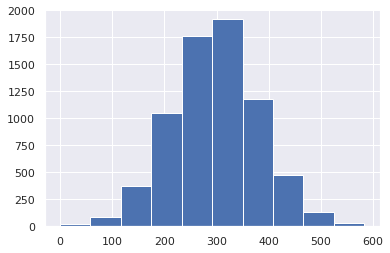

In [36]:
plt.figure(figsize=(6, 4))
df_contract['difference'].hist()

In [37]:
df_contract['difference'].mean()

297.37867386057076

Имеем нормальное распределение, т.е. большинство человек, которые все таки не продолжат оплату, не продолжают оплату после 300 дней. 

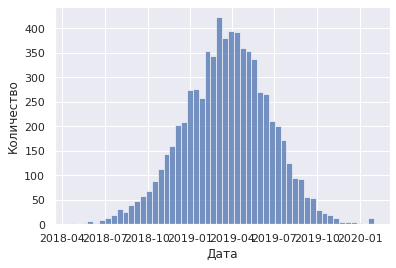

In [38]:
plt.figure(figsize=(6, 4))
sns.histplot(df_contract['begindate']);
plt.xlabel('Дата');
plt.ylabel('Количество');

Большинство клиентов пришло в 2019 году, в Апреле, после чего видим спад. Видимо, в 2019 году была серьёзная реклама, которая привела столько людей.

In [39]:
df_contract.groupby(['target', 'type'], as_index=False)['customerid'].count()

,target,type,customerid
0,0,Month-to-month,1655
1,0,One year,166
2,0,Two year,48
3,1,Month-to-month,2220
4,1,One year,1307
5,1,Two year,1647


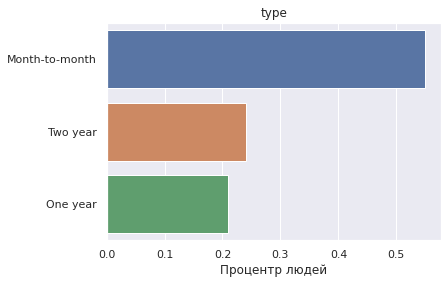

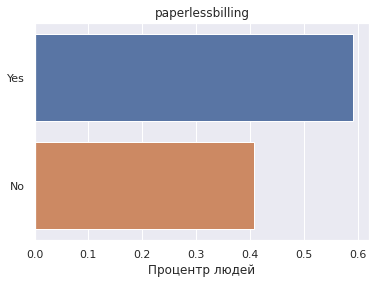

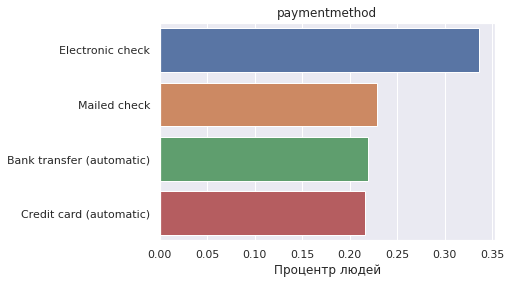

In [40]:
for column in df_contract.columns[3:-4]:
    plt.figure(figsize=(6, 4));
    sns.barplot(y=df_contract[column].value_counts(normalize=True).index, x=df_contract[column].value_counts(normalize=True));
    plt.xlabel('Процентр людей');
    plt.title(column)

Очень большой процент человек оплачивают услуги раз в месяц, остальные оплачивают 2 раза в год и 1 раз в год. 59 процентов человек используют безбумажный расчётный лист, 41 не использует. 33,5 процента пользуются электронным чеком, 23 процента почтовым чеком, 22 процента банковским переводом автоматически, 21 процент кредиткой автоматически.

In [41]:
df_contract.groupby(['paymentmethod', 'type'])['type'].count()

paymentmethod              type          
Bank transfer (automatic)  Month-to-month     589
                           One year           391
                           Two year           564
Credit card (automatic)    Month-to-month     543
                           One year           398
                           Two year           581
Electronic check           Month-to-month    1850
                           One year           347
                           Two year           168
Mailed check               Month-to-month     893
                           One year           337
                           Two year           382
Name: type, dtype: int64

Месяц к месяцу самое большое количество людей оплачивают электронным чеком, кредитной картой чаще оплачивают 2 раза в год услуги, а также раз в год.

In [42]:
df_contract.groupby(['paymentmethod'])['totalcharges'].sum().sort_values(ascending=False)

paymentmethod
Electronic check             4944903.25
Bank transfer (automatic)    4748279.90
Credit card (automatic)      4671593.35
Mailed check                 1691392.20
Name: totalcharges, dtype: float64

С почтового чека самое минимальное получение денег среди всех остальных способов оплаты, больше всего денег получили с помощью электронных чеков. В целом можно сказать, что почтовые чеки используют очень мало, остальные способы оплаты актуальны.

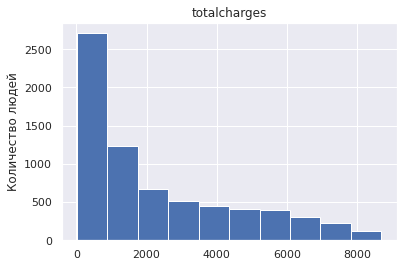

In [43]:
for column in df_contract.columns[-3:-2]:
    plt.figure(figsize=(6, 4));
    df_contract[column].hist()
    plt.ylabel('Количество людей');
    plt.title(column)

Большинство людей тратит не такую большую сумму в целом, т.к. у нас экспоненциальное распределение.

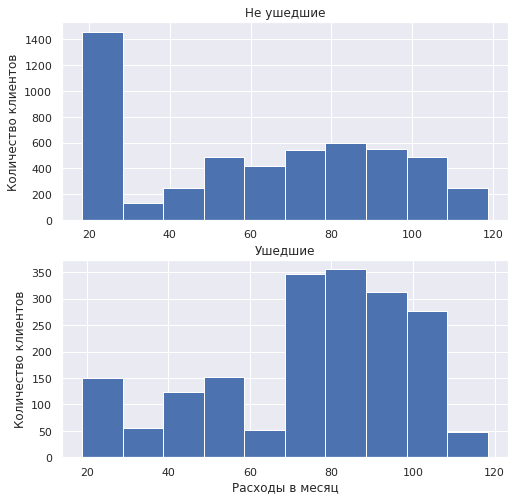

In [44]:
f, (ax_one, ax_null) = plt.subplots(2, figsize=(8, 8))
df_contract[df_contract['target'] == 1]['monthlycharges'].hist(ax=ax_one);
df_contract[df_contract['target'] == 0]['monthlycharges'].hist(ax=ax_null);

ax_one.set(title='Не ушедшие', ylabel='Количество клиентов');
ax_null.set(title='Ушедшие', xlabel='Расходы в месяц', ylabel='Количество клиентов');

In [45]:
df_contract.groupby('target')['monthlycharges'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35
1,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75


**Не ушедшие:** очень большое количество клиентов тратит 20 долларов ежемесячно, есть такие, которые тратят сумму больше, от 50 до 100. Видимо, большинство тех, кто не уходит, удовлетворяет самый дешевый тариф.

Не ушедшие клиенты тратили меньше денег, чем те, кто ушёл. Средняя трата по не ушедшим - 61, а медианна 64, также у не ушедших меньше минимальная стоимость услуг и чуть больше по максимальной.

**Ушедшие:** Большинство клиентов, которые ушли, тратили ежемесячно от 70 до 110 долларов. Можно предположить, что им не нравился тариф, т.е. он не соответствовал критерию цена/качество, следовательно, клиент уходил.

Средняя трата у ушедших абонентов 74, медиана 80.

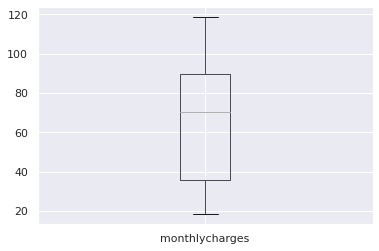

In [46]:
df_contract.boxplot(column='monthlycharges');

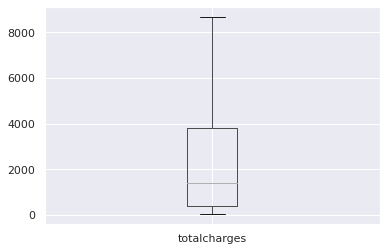

In [47]:
df_contract.boxplot(column='totalcharges');

Выбросов по численным столбцам нет

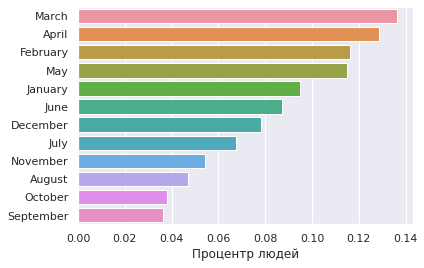

In [48]:
plt.figure(figsize=(6, 4));
sns.barplot(y=df_contract['begindate'].dt.month_name().value_counts().index, 
            x=df_contract['begindate'].dt.month_name().value_counts(normalize=True));
plt.xlabel('Процентр людей');

Чаще всего люди приходят весной, в Марте и Апреле больше всего. Хуже всего осенью.

In [49]:
df_contract['month_begin'] = df_contract['begindate'].dt.month_name()

In [50]:
df_contract.groupby(['month_begin', 'target'])['monthlycharges'].count().sort_values(ascending=False)

month_begin  target
March        1         741
April        1         739
May          1         702
February     1         602
June         1         543
January      1         425
July         1         403
December     1         300
             0         252
August       1         245
January      0         244
March        0         219
February     0         218
November     0         198
             1         183
April        0         166
September    1         156
October      1         135
             0         134
May          0         109
September    0         101
August       0          85
June         0          72
July         0          71
Name: monthlycharges, dtype: int64

Большее количество клиентов, которые приходят весной, остаются. Самый ужасный месяц, в котором приходят - Декабрь. Почти все клиенты, которые пришли в Декабре, ушли.

# df_personal

In [51]:
df_personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [52]:
len(df_personal['customerid'].unique())

7043

7043 уникальных пользователя

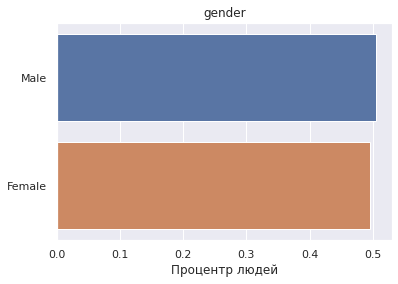

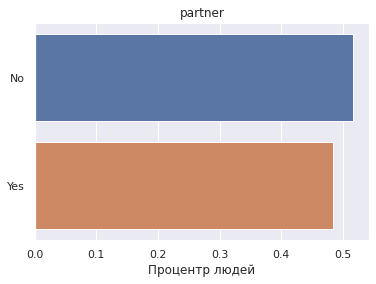

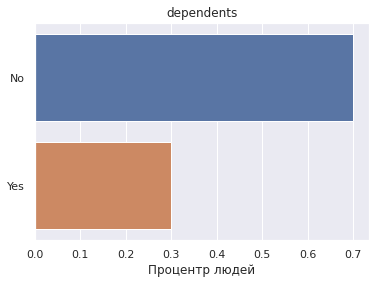

In [53]:
for column in df_personal.columns[1:]:
    if column != 'seniorcitizen':
        plt.figure(figsize=(6, 4));
        sns.barplot(y=df_personal[column].value_counts(normalize=True).index, x=df_personal[column].value_counts(normalize=True));
        plt.xlabel('Процентр людей');
        plt.title(column)

In [54]:
df_personal['seniorcitizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: seniorcitizen, dtype: float64

83 процента клиентов не являются пенсионерами. 70 процент клиентов не имеют детей, 30 процентов имеют. У 52 процентов есть супруга/супрун, у 48 процентов нет. Мужчин и женщин почти поровну

# Полная таблица

Что я собираюсь делать? Пропуски удалю, т.к. мало значений с пропусками. Так бы делал 2 датафрейме, где для линейных моделей заменял бы на 0, а для нелинейных на аномальное значение, чтобы деревья выделяли группу и сами решали, как поступать.

В категориалных признаках буду заменять на UNK(unknow)

In [55]:
data = df_contract.merge(df_personal, on='customerid', how='left')
data = data.merge(df_internet, on='customerid', how='left')
data = data.merge(df_phone, on='customerid', how='left')

In [56]:
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,target,difference,month_begin,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,1,0,February,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,1,0,February,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,479,August,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,1,0,February,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,279,January,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
 9   difference        7043 non-null   int64         
 10  month_begin       7043 non-null   object        
 11  gender            7043 non-null   object        
 12  seniorcitizen     7043 non-null   int64         
 13  partner           7043 non-null   object        
 14  dependents        7043 n

In [58]:
data.describe()

,monthlycharges,totalcharges,target,difference,seniorcitizen
count,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2283.300441,0.734630,297.378674,0.162147
std,30.090047,2266.771362,0.441561,83.868181,0.368612
min,18.250000,18.800000,0.000000,0.000000,0.000000
25%,35.500000,401.450000,0.000000,242.000000,0.000000
50%,70.350000,1397.475000,1.000000,298.000000,0.000000
75%,89.850000,3794.737500,1.000000,351.000000,0.000000
max,118.750000,8684.800000,1.000000,583.000000,1.000000


In [59]:
columns_new = ['id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges',
               'total_charges', 'target', 'difference', 'month_begin', 'gender', 'senior_citizen',
               'partner', 'dependents', 'internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

data.columns = columns_new

In [60]:
index_drop = data[data['total_charges'].isna()].index
data = data.drop(index_drop)
for column in data.columns[15:]:
    data[column] = data[column].fillna('UNK')
    
data = data.reset_index(drop=True)

In [61]:
data = data.drop(['end_date'], axis=1)

In [62]:
data = data.drop(['begin_date', 'month_begin'], axis=1)

In [63]:
active = data[data['target'] == 1]
not_active = data[data['target'] == 0]

In [64]:
data.shape[0]

7032

Рассчитаем количество людей, которые подключены к телефонии и интернету, а также тех людей, которые подключены одновременно и к телефонии, и к интернету.

In [65]:
telephony_active = active[active['internet_service'] == 'UNK'].shape[0]
telephony_not_active = not_active[not_active['internet_service'] == 'UNK'].shape[0]
internet_active = active[active['multiple_lines'] == 'UNK'].shape[0]
internet_not_active = not_active[not_active['multiple_lines'] == 'UNK'].shape[0]
telephony_internet_active = active.shape[0] - (telephony_active + internet_active)
telephony_internet_not_active = not_active.shape[0] - (telephony_not_active + internet_not_active)

In [66]:
active_pie = pd.DataFrame([telephony_active, internet_active, telephony_internet_active], 
                           index=['telephony', 'internet', 'telephont_and_internet'], columns=['abonents'])
not_active_pie = pd.DataFrame([telephony_not_active, internet_not_active, telephony_internet_not_active], 
                           index=['telephony', 'internet', 'telephont_and_internet'], columns=['abonents'])

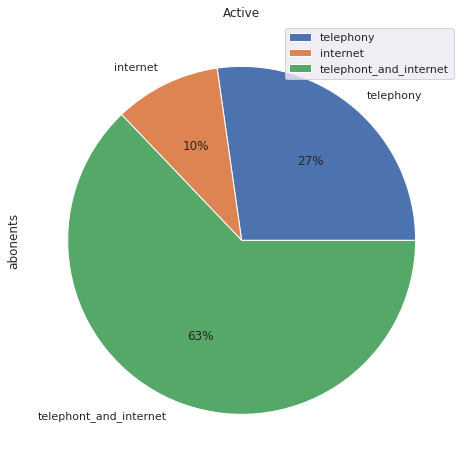

In [67]:
active_pie.plot.pie(y='abonents', figsize=(10, 8), autopct='%1.0f%%');
plt.title('Active');

У активных абонентов, которые не ушли, 63 процента подлючены и к телефонии, и к интернету, 10 процентов к интернету и 27 процентов к телефонии.

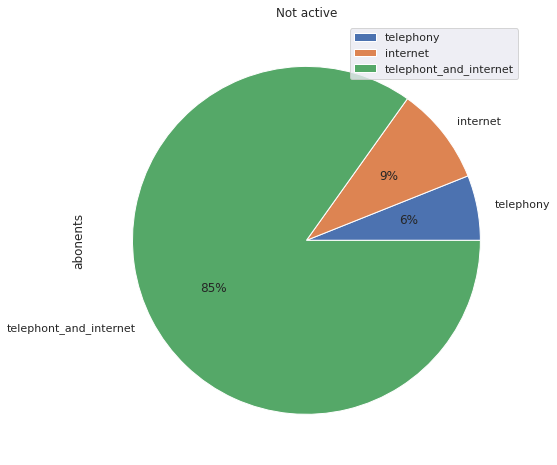

In [68]:
not_active_pie.plot.pie(y='abonents', figsize=(10, 8), autopct='%1.0f%%');
plt.title('Not active');

У абонентов, которые не ушли, 85 процента подлючены и к телефонии, и к интернету, 9 процентов к интернету и 6 процентов к телефонии.

Возможно, этих людей могло беспокоить то, что нет определенного тарифа под интернет и связь одновременно.

In [69]:
cat = ['type', 'paperless_billing', 'payment_method', 'gender', 'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

df_corr = data.copy()

encoder = OrdinalEncoder()
df_corr[cat] = encoder.fit_transform(df_corr[cat])

In [70]:
df_corr = df_corr.drop(['id'], axis=1)

interval columns not set, guessing: ['type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges', 'target', 'difference', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


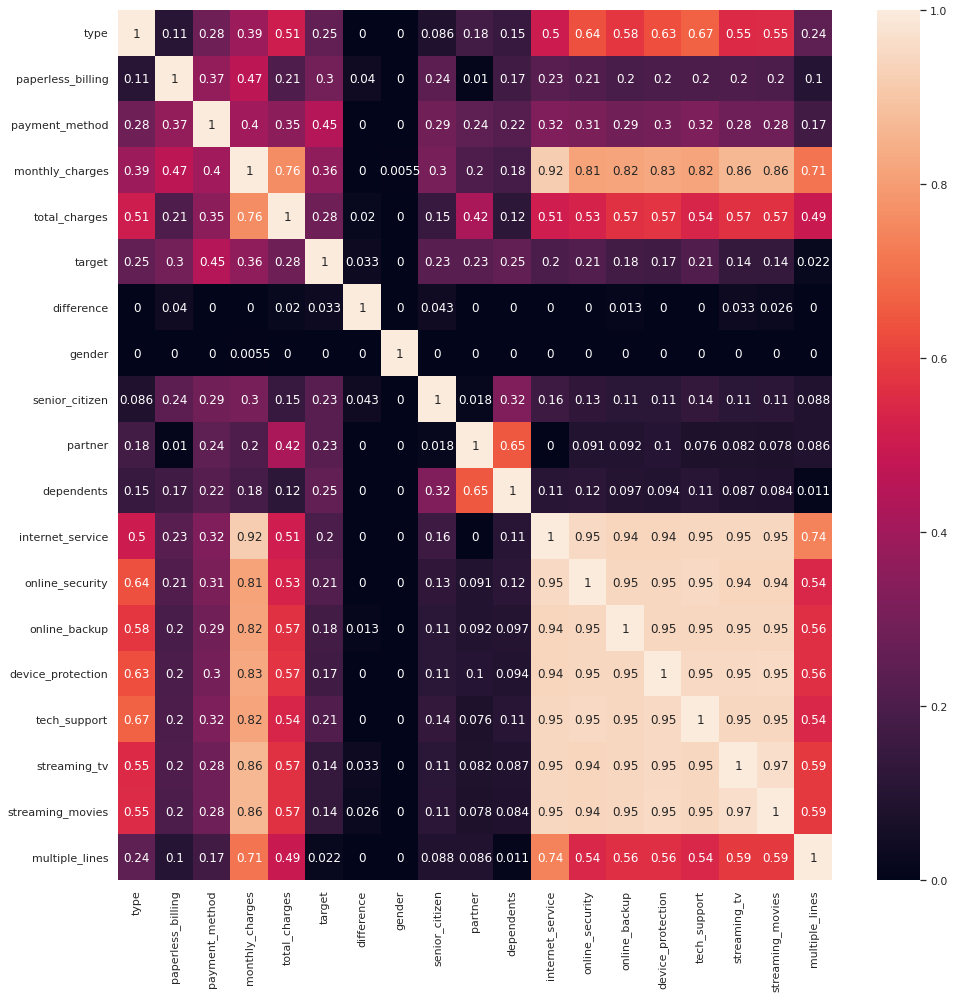

In [71]:
plt.figure(figsize=(16, 16))
sns.heatmap(df_corr.phik_matrix(), annot=True);

Имеется большая зависимость между большлинством категориальных признаков, а также таргет коррелирует с на то, есть ли у человека супруг/супруга. Ничего удалять не буду

Решил испитать предобработку текстовых признаков с помощью tf-idf, а не ohe, те признаки, которые имеют значения Да/Нет - предобрабатываю ohe.

In [72]:
count_vect = TfidfVectorizer()

text = ['payment_method', 'gender', 'internet_service', 'type']

text_vector = pd.DataFrame(count_vect.fit_transform(data['type']).toarray(), columns=count_vect.get_feature_names_out())

for column in text[:-1]:
    text_vector = text_vector.join(pd.DataFrame(count_vect.fit_transform(data[column]).toarray(), 
                                   columns=count_vect.get_feature_names_out()))

data = data.join(text_vector)
data = data.drop(text, axis=1)

In [73]:
features = data.drop(['target', 'id'], axis=1)
target = data['target']

In [74]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target, test_size=0.4, random_state=67)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, random_state=67)


x_train_cat, x_valid_cat, y_train_cat, y_valid_cat = train_test_split(features, target, test_size=0.4, random_state=67)

x_valid_cat, x_test_cat, y_valid_cat, y_test_cat = train_test_split(x_valid_cat, y_valid_cat, test_size=0.5, random_state=67)

x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [75]:
num = ['total_charges', 'monthly_charges', 'senior_citizen', 'month', 'one', 'to', 'two', 'year', 
       'automatic', 'bank', 'card', 'difference',
       'check', 'credit', 'electronic', 'mailed', 'transfer', 'female', 'male',
       'dsl', 'fiber', 'optic', 'unk']

cat = ['paperless_billing', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

ohe = OneHotEncoder(drop='first')
ohe_df_train = ohe.fit_transform(np.array(x_train[cat]))
ohe_df_valid = ohe.transform(np.array(x_valid[cat]))
ohe_df_test = ohe.transform(np.array(x_test[cat]))

ohe_df_train = pd.DataFrame(ohe_df_train.todense(), columns=ohe.get_feature_names_out())
ohe_df_valid = pd.DataFrame(ohe_df_valid.todense(), columns=ohe.get_feature_names_out())
ohe_df_test = pd.DataFrame(ohe_df_test.todense(), columns=ohe.get_feature_names_out())

x_train = x_train[num].join(ohe_df_train)
x_valid = x_valid[num].join(ohe_df_valid)
x_test = x_test[num].join(ohe_df_test)



In [76]:
scaler = StandardScaler()
x_train[num] = scaler.fit_transform(x_train[num])
x_valid[num] = scaler.transform(x_valid[num])
x_test[num] = scaler.transform(x_test[num])

In [77]:
# выборки train + valid для обучения лучшей модели
x_train_valid = np.concatenate([x_train.values, x_valid.values])
y_train_valid = np.concatenate([y_train.values, y_valid.values])

x_train_valid_cat = pd.DataFrame(np.concatenate([x_train_cat.values, x_valid_cat.values]), columns=x_train_cat.columns)
y_train_valid_cat = np.concatenate([y_train_cat.values, y_valid_cat.values])

# Обучение моделей

Использую метрики ROC-AUC и accuracy

In [78]:
lr = LogisticRegression()
lr.fit(x_train_valid, y_train_valid)
pred = lr.predict_proba(x_test)[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, pred))

ROC-AUC: 0.833885772565018


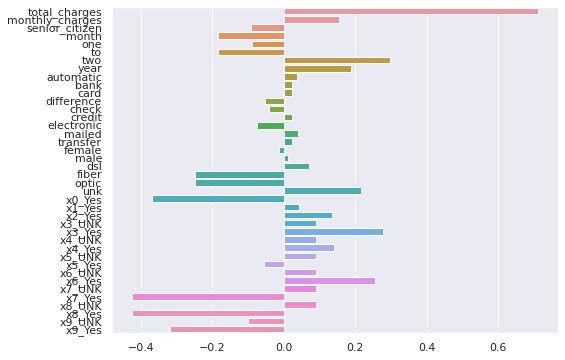

In [79]:
plt.figure(figsize=(8, 6));
sns.barplot(x=lr.coef_[0], y=x_train.columns);

## RandomForest

In [80]:
parameters = {
    'n_estimators': [100, 200, 400, 800, 1000],
    'max_depth': [6, 12, 18]
}


rfc = RandomForestClassifier(max_features='sqrt',
                             class_weight='balanced')
gs = GridSearchCV(rfc, parameters, cv=10, n_jobs=-1, scoring='roc_auc')
gs.fit(x_train_valid, y_train_valid)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features='sqrt'),
             n_jobs=-1,
             param_grid={'max_depth': [6, 12, 18],
                         'n_estimators': [100, 200, 400, 800, 1000]},
             scoring='roc_auc')

In [81]:
gs.best_score_, gs.best_params_

(0.8402082934239106, {'max_depth': 6, 'n_estimators': 800})

In [82]:
prediction = gs.best_estimator_.predict_proba(x_test)[:, 1]
print('ROC-AUC:', roc_auc_score(y_test, prediction))

ROC-AUC: 0.8332561479461749


Неплохие результаты для случайного реша, попробую бустинг

## CatBoost

In [83]:
cat = list(x_train_cat.drop(num, axis=1).columns)

In [84]:
cat

['paperless_billing',
 'partner',
 'dependents',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [85]:
train_pool = Pool(data=x_train_cat, label=y_train_cat, cat_features=cat)
valid_pool = Pool(data=x_valid_cat, label=y_valid_cat, cat_features=cat)
train_valid_pool = Pool(data=x_train_valid_cat, label=y_train_valid_cat, cat_features=cat)

In [86]:
def objective(trial):

    param = {
        "depth": trial.suggest_int("depth", 5, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'loss_function': trial.suggest_categorical('loss_function', ["CrossEntropy"])
    }

    model = CatBoostClassifier(**param, verbose=False, allow_writing_files=False)
    model.fit(train_pool, eval_set=valid_pool)

    score = roc_auc_score(y_valid_cat, model.predict_proba(x_valid_cat)[:, 1])

    return score

In [101]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600, n_jobs=-1)

[I 2022-11-12 17:09:45,300] A new study created in memory with name: no-name-7026a7d6-c3ee-4f99-85a4-7ae528323e74
[I 2022-11-12 17:10:21,249] Trial 0 finished with value: 0.8338182993857096 and parameters: {'depth': 10, 'n_estimators': 487, 'learning_rate': 0.05158935248336002, 'loss_function': 'CrossEntropy'}. Best is trial 0 with value: 0.8338182993857096.
[I 2022-11-12 17:10:24,483] Trial 2 finished with value: 0.8321991593921759 and parameters: {'depth': 7, 'n_estimators': 194, 'learning_rate': 0.010150992600283688, 'loss_function': 'CrossEntropy'}. Best is trial 0 with value: 0.8338182993857096.
[I 2022-11-12 17:10:37,793] Trial 1 finished with value: 0.8328897510507598 and parameters: {'depth': 9, 'n_estimators': 837, 'learning_rate': 0.015599298919981372, 'loss_function': 'CrossEntropy'}. Best is trial 0 with value: 0.8338182993857096.
[I 2022-11-12 17:10:46,189] Trial 4 finished with value: 0.8380536695764631 and parameters: {'depth': 5, 'n_estimators': 449, 'learning_rate': 0.

CPU times: user 6min 37s, sys: 29.4 s, total: 7min 7s
Wall time: 3min 46s


In [102]:
study.best_params, study.best_value

({'depth': 5,
  'n_estimators': 307,
  'learning_rate': 0.1310337545045173,
  'loss_function': 'CrossEntropy'},
 0.8412479793081151)

In [103]:
cb = CatBoostClassifier(max_depth=5, n_estimators=307, learning_rate=0.1310337545045173, 
                        loss_function='CrossEntropy', verbose=False)
cb.fit(train_valid_pool)

print('ROC-AUC:', roc_auc_score(y_test_cat, cb.predict_proba(x_test_cat)[:, 1]))

ROC-AUC: 0.8418913715409672


Бустинг показал результаты лучше, чем у логистической регрессии и случайного леса, попробую нейронные сети.

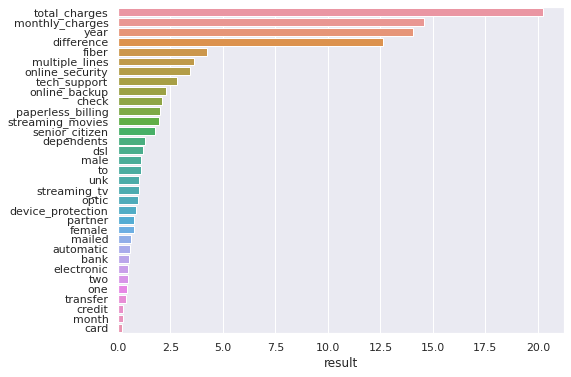

In [104]:
result = pd.DataFrame(cb.feature_importances_, index=x_train_cat.columns, 
                      columns=['result']).sort_values(by='result', ascending=False)
plt.figure(figsize=(8, 6));
sns.barplot(x=result['result'], y=result.index);

Видно, что самая большая важность у признака общей суммы расходов, после идеи месячные расходы, а потом время жизни клиента.

## Нейронная сеть

In [91]:
# функции обучения и графика

def AUC(y_true, pred):
    return roc_auc_score(y_true, pred)




def train_model(x_train, y_train, x_valid, y_valid, model, n_e=100, lr=1e-3, l=nn.BCEWithLogitsLoss()):
    

    result = {'Epoch': [], 'score_train': [], 'score_test': []}
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss = l

    num_epochs = n_e

    for epoch in range(num_epochs):


        optimizer.zero_grad()

        preds = model(x_train).squeeze()

        loss_value = loss(preds, y_train)
        loss_value.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
            train_preds = model(x_train).squeeze()
            test_preds = model(x_valid).squeeze()
            score_train = AUC(y_train.cpu().numpy(), train_preds.cpu().numpy()) 
            score_test = AUC(y_valid.cpu().numpy(), test_preds.cpu().numpy()) 

        if epoch % 2 == 0:
            print('|| Epoch: {}  || Loss: {} || score: {} ||'.format(epoch, loss_value, score_test))

        if epoch == (num_epochs - 1):
            print('End!')

        result['Epoch'].append(epoch)
        result['score_train'].append(score_train)
        result['score_test'].append(score_test)
        
    return result



def graf_result(df):
    plt.figure(figsize=(10, 8), )
    plt.plot(df['score_train'])
    plt.plot(df['score_test'])
    plt.xlabel('epoh')
    plt.ylabel('ROC-AUC')
    plt.grid(True)
    plt.legend(['train', 'valid'])
    plt.show()

In [92]:
x_train_tensor = torch.Tensor(x_train.values).to(device)
x_valid_tensor = torch.Tensor(x_valid.values).to(device)
x_test_tensor = torch.Tensor(x_test.values).to(device)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_valid_tensor = torch.Tensor(y_valid.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)

In [93]:
class NeuralNetBase(nn.Module):
    def __init__(self, n_in, n_2, n_3, n_4, n_out, 
                 p1, p2, p3, 
                 activation1, activation2, activation3):
        super(NeuralNetBase, self).__init__()
        
        self.f1 = nn.Linear(n_in, n_2) 
        self.a1 = activation1
        self.drop1 = nn.Dropout(p1)
        
        self.f2 = nn.Linear(n_2, n_3)
        self.a2 = activation2
        self.drop2 = nn.Dropout(p2)

        self.f3 = nn.Linear(n_3, n_4) 
        self.a3 = activation3
        self.drop3 = nn.Dropout(p3)

        self.f4 = nn.Linear(n_4, n_out)
        self.init_weights()
        

    def forward(self, x):
        x = self.drop1(self.a1(self.f1(x)))
        x = self.drop2(self.a2(self.f2(x)))
        x = self.drop3(self.a3(self.f3(x)))
        x = self.f4(x)
        
        
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)


model = NeuralNetBase(x_train_tensor.shape[-1], 2048, 1024, 512, 1, 0.3, 0.3, 0.2, nn.ReLU(), nn.LeakyReLU(), nn.ReLU()).to(device)

In [94]:
result = train_model(x_train_tensor, y_train_tensor, x_valid_tensor, y_valid_tensor, model, lr=1e-3, n_e=20)

|| Epoch: 0  || Loss: 0.7056295871734619 || score: 0.7921862269641124 ||
|| Epoch: 2  || Loss: 0.48054152727127075 || score: 0.8123194309731652 ||
|| Epoch: 4  || Loss: 0.44814053177833557 || score: 0.8178545101842871 ||
|| Epoch: 6  || Loss: 0.44717609882354736 || score: 0.8227455544778532 ||
|| Epoch: 8  || Loss: 0.4422677755355835 || score: 0.8234309731652117 ||
|| Epoch: 10  || Loss: 0.4352979362010956 || score: 0.8246466214031685 ||
|| Epoch: 12  || Loss: 0.4284992218017578 || score: 0.8263847397348852 ||
|| Epoch: 14  || Loss: 0.4237549901008606 || score: 0.8272641448431942 ||
|| Epoch: 16  || Loss: 0.41967982053756714 || score: 0.8300394439055934 ||
|| Epoch: 18  || Loss: 0.4138505160808563 || score: 0.8344623343032654 ||
End!


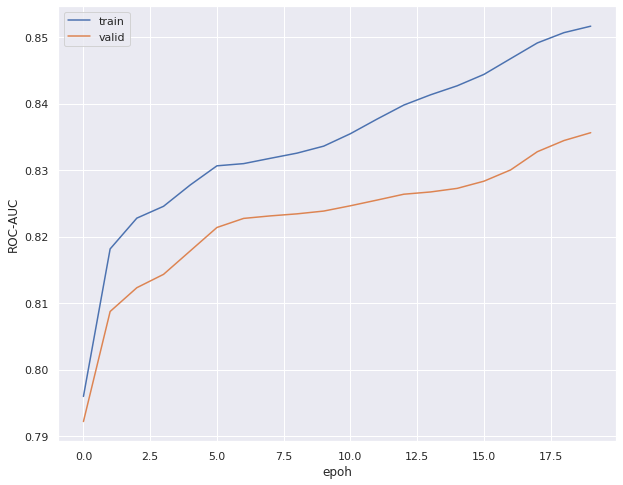

In [95]:
df_result = pd.DataFrame(result)
graf_result(df_result)

Нейронка обучилась, результаты хуже бустинга

# Тестирование модели



Лучшая модель - catboost, на ее основе будем проводить тестирование

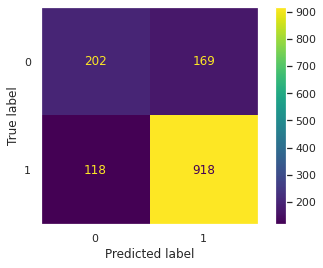

In [96]:
plot_confusion_matrix(cb, x_test_cat, y_test_cat)
plt.grid(False)
plt.show()

Получился маленький recall и большой precision

In [97]:
precision, recall, thresholds = precision_recall_curve(y_test_cat, cb.predict_proba(x_test_cat)[:, 1])

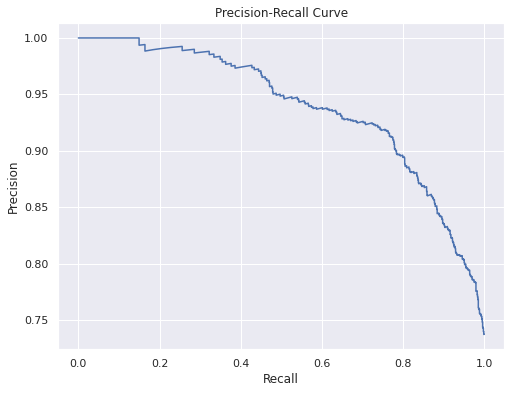

In [98]:
plt.figure(figsize=(8, 6));
plt.plot(recall, precision);

plt.title('Precision-Recall Curve');
plt.ylabel('Precision');
plt.xlabel('Recall');

In [105]:
# лучший результат моделей
print('Лучший ROC-AUC:', roc_auc_score(y_test_cat, cb.predict_proba(x_test_cat)[:, 1]))

Лучший ROC-AUC: 0.8418913715409672


**Вывод:** В данном проекте я провел исследовательский анализ данных, предобработал их, также попробовал несколько моделей: логистическую регрессию, случайный лес, catboost, нейронную сеть. Лучшие результаты показала модель catboost - **0.841 roc-auc**. Что бы я посоветовал? Делать какие-либо скидки, либо изменение/предложение тарифов, которые выгодны абоненту, т.к. ушедшие клиенты тратили больше денег, чем те, кто остался.